## Data Prep Work Flow : Fuel Tiles

In [1]:
import gdal
import osr
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DG='/home/mcmccart/WIFIRE/Raw_Data/DigitalGlobe/'
LF='/home/mcmccart/WIFIRE/Raw_Data/LANDFIRE/'
Clip='/home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/'
Proj='/home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/'
Tile='/home/mcmccart/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/TIFF_Files/'

In [3]:
def ClipFile(SE,FileName,OutFile):
    #Input:
        # SE - Spatial Extent - [x1, y1, x2, y2]
        # Filename - name of file you wish to clip
    # OutFile - name of file you want to create
    gdal_str="/opt/anaconda3/bin/gdal_translate -projwin "+str.format('{0:.13f}', SE[0])+\
    " "+str.format('{0:.13f}', SE[1])+" "+str.format('{0:.13f}', SE[2])+\
    " "+str.format('{0:.13f}', SE[3])+" "+FileName+" "+OutFile
    os.system(gdal_str)
        
def GrabCornerCoordinates(FileName):
    src = gdal.Open(FileName)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)
    return [ulx,uly,lrx,lry]
        
def IntersectBox(CC1,CC2):
    # Import:  Corner Coordinates in [Upper Left Long, Upper Left Lat, Lower Right Long, Lower Right Lat]
    # Note -- Assuming coordinates are in San Diego (aka - Long and + Lat)
    
    #Upper Left:
    ulx=max(CC1[0],CC2[0])
    uly=min(CC1[1],CC2[1])
    
    #Lower Right:
    lrx=min(CC1[2],CC2[2])
    lry=max(CC1[3],CC2[3])
    
    return [ulx,uly,lrx,lry]

def ToWGS84(FileName,OutName):
    gdal_str="/opt/anaconda3/bin/gdalwarp -t_srs wgs84 "+FileName +" "+OutName
    print(gdal_str)
    os.system(gdal_str)
    
def ToXYZ(FileName, OutName):
    gdal_str="/opt/anaconda3/bin/gdal_translate -of XYZ "+FileName +" "+OutName
    print(gdal_str)
    os.system(gdal_str)
    
def ImportXYZ(FileName,labelName):
    DF=pd.read_table(FileName, header=None)
    DF.columns=['Row']
    DF["Long"]=DF["Row"].apply(lambda x: float(x.split(" ")[0]))
    DF["Lat"]=DF["Row"].apply(lambda x: float(x.split(" ")[1]))
    DF[labelName]=DF["Row"].apply(lambda x: x.split(" ")[2])
    del DF["Row"]
    return DF

def Check_PlotExtentions(boxes,SE,plotname=None):
    #Input:
        #boxes -- dict of corner points (aka list of list), with [Upper Left Long, Upper Left Lat, Lower Right Long, Lower Right Lat]
    i=0
    color1=['-k','-b','-g','-m','-o','-c']
    plt.figure(figsize=(12,8))
    for k in boxes.keys():
        X=[boxes[k][0],boxes[k][2],boxes[k][2],boxes[k][0],boxes[k][0]]
        Y=[boxes[k][1],boxes[k][1],boxes[k][3],boxes[k][3],boxes[k][1]]
        plt.plot(X,Y,color1[i],label=k,linewidth=2.0)
        i+=1
    
    i=0
    color2=['--r','--y','--c','--o','--g']
    for k in SE:
        X=[SE[k][0],SE[k][2],SE[k][2],SE[k][0],SE[k][0]]
        Y=[SE[k][1],SE[k][1],SE[k][3],SE[k][3],SE[k][1]]
        plt.plot(X,Y,color2[i],label=k,linewidth=4.0) 
        i+=1
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if plotname!= None:
        plt.savefig(plotname+'.png')
        
def GetBorder(cx,cy,xres,yres):
    ulx=cx-0.5*xres
    uly=cy-0.5*yres
    lrx=ulx+xres
    lry=uly+yres
    return [ulx,uly,lrx,lry]

def GrabRes(FileName):
    src = gdal.Open(FileName)
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    return [xres,yres]

Clip  all Fuel Years to the same spatial extent and then Re-Project onto  WGS84

In [35]:
fuel2014=GrabCornerCoordinates(LF+'sandiego-fuel-2014.tif')
fuel2012=GrabCornerCoordinates(LF+'sandiego-fuel-2012.tif')
fuel2010=GrabCornerCoordinates(LF+'sandiego-fuel-2010.tif')

# Vegetation too
veg2014=GrabCornerCoordinates(LF+'sandiego-vegtype-2014.tif')
veg2012=GrabCornerCoordinates(LF+'sandiego-vegtype-2012.tif')
veg2010=GrabCornerCoordinates(LF+'sandiego-vegtype-2010.tif')

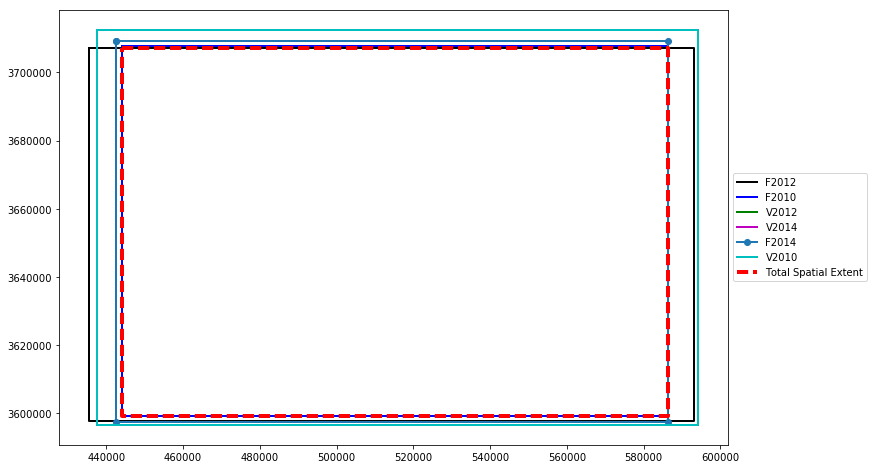

In [37]:
#Find Spatial Extent of LandFire & Sat data
f10_12=IntersectBox(fuel2010,fuel2012)
f10_12_14=IntersectBox(f10_12,fuel2014)
v10_f=IntersectBox(f10_12_14,veg2010)
V10_12_f=IntersectBox(v10_f,veg2012)
SE=IntersectBox(V10_12_f,veg2014)


data={'F2010':fuel2010,'F2012': fuel2012,'F2014': fuel2014,'V2010':veg2010,'V2012': veg2012,'V2014': veg2014}
intersect={'Total Spatial Extent':SE}
Check_PlotExtentions(data,intersect)

In [38]:
ClipFile(SE,LF+'sandiego-fuel-2014.tif',Clip+'Clip_SanDiego_Fuel2014_UTM.tif')
ClipFile(SE,LF+'sandiego-fuel-2012.tif',Clip+'Clip_SanDiego_Fuel2012_UTM.tif')
ClipFile(SE,LF+'sandiego-fuel-2010.tif',Clip+'Clip_SanDiego_Fuel2010_UTM.tif')

ClipFile(SE,LF+'sandiego-vegtype-2014.tif',Clip+'Clip_SanDiego_Veg2014_UTM.tif')
ClipFile(SE,LF+'sandiego-vegtype-2012.tif',Clip+'Clip_SanDiego_Veg2012_UTM.tif')
ClipFile(SE,LF+'sandiego-vegtype-2010.tif',Clip+'Clip_SanDiego_Veg2010_UTM.tif')

In [39]:
ToWGS84(Clip+'Clip_SanDiego_Fuel2014_UTM.tif',Proj+'Clip_SanDiego_Fuel2014_UTM_ReProj.tif')
ToWGS84(Clip+'Clip_SanDiego_Fuel2012_UTM.tif',Proj+'Clip_SanDiego_Fuel2012_UTM_ReProj.tif')
ToWGS84(Clip+'Clip_SanDiego_Fuel2010_UTM.tif',Proj+'Clip_SanDiego_Fuel2010_UTM_ReProj.tif')

ToWGS84(Clip+'Clip_SanDiego_Veg2014_UTM.tif',Proj+'Clip_SanDiego_Veg2014_UTM_ReProj.tif')
ToWGS84(Clip+'Clip_SanDiego_Veg2012_UTM.tif',Proj+'Clip_SanDiego_Veg2012_UTM_ReProj.tif')
ToWGS84(Clip+'Clip_SanDiego_Veg2010_UTM.tif',Proj+'Clip_SanDiego_Veg2010_UTM_ReProj.tif')

/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_SanDiego_Fuel2014_UTM.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/Clip_SanDiego_Fuel2014_UTM_ReProj.tif
/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_SanDiego_Fuel2012_UTM.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/Clip_SanDiego_Fuel2012_UTM_ReProj.tif
/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_SanDiego_Fuel2010_UTM.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/Clip_SanDiego_Fuel2010_UTM_ReProj.tif
/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_SanDiego_Veg2014_UTM.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/Clip_SanDiego_Veg2014_UTM_ReProj.tif
/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_SanDiego_Veg2012

Clip Fuel and Satellite data to the same "Escondido" spatial extent

In [40]:
sat2014=GrabCornerCoordinates(DG+'Escondido2014.tif')
sat2012=GrabCornerCoordinates(DG+'Escondido2012v3.tif')
sat2010=GrabCornerCoordinates(DG+'escondido2010.tif')

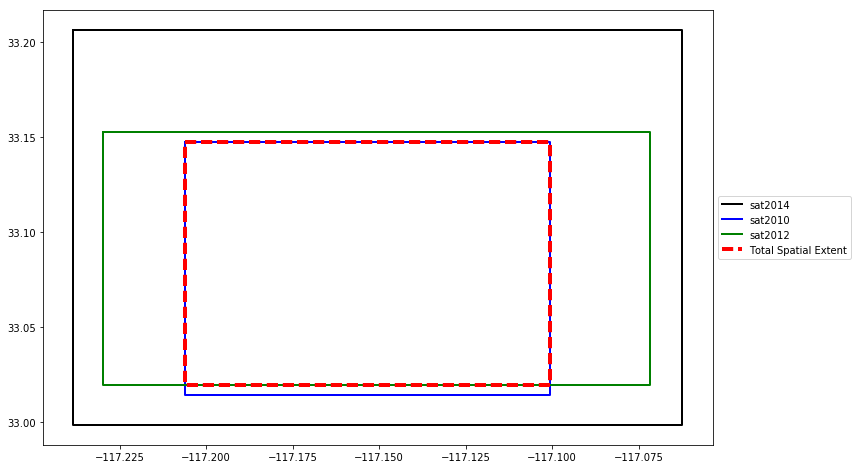

In [41]:
#Find Spatial Extent of LandFire & Sat data
s10_12=IntersectBox(sat2010,sat2012)
SE=IntersectBox(s10_12,sat2014)


data={'sat2010':sat2010,'sat2012': sat2012,'sat2014': sat2014}
intersect={'Total Spatial Extent':SE}
Check_PlotExtentions(data,intersect)

In [42]:
SE

[-117.2060065897892,
 33.147178567916804,
 -117.10070755895937,
 33.01953127007837]

[-117.2060065897892, 33.1471785679168, -117.1007075589594, 33.0195312700784]


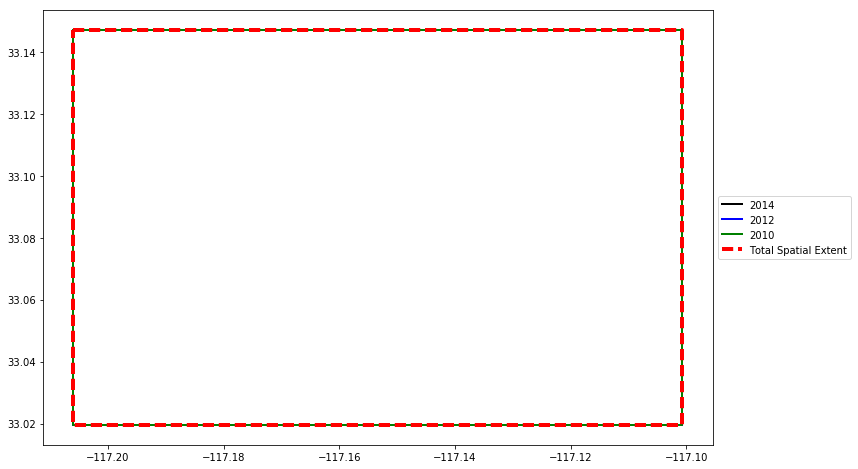

In [43]:
# Have to Clip Fuel first then recalculate spatial extent based on those clips
# We then clip Satellite data to this new spatial extent.  Higher resolution satellite data approximates the Lower resolution Fuel data
ClipFile(SE,Proj+'Clip_SanDiego_Fuel2014_UTM_ReProj.tif',Clip+'Clip_Fuel2014_Escondido_18May2017.tif')
ClipFile(SE,Proj+'Clip_SanDiego_Fuel2012_UTM_ReProj.tif',Clip+'Clip_Fuel2012_Escondido_18May2017.tif')
ClipFile(SE,Proj+'Clip_SanDiego_Fuel2010_UTM_ReProj.tif',Clip+'Clip_Fuel2010_Escondido_18May2017.tif')
ClipFile(SE,Proj+'Clip_SanDiego_Veg2014_UTM_ReProj.tif',Clip+'Clip_Veg2014_Escondido_18May2017.tif')
ClipFile(SE,Proj+'Clip_SanDiego_Veg2012_UTM_ReProj.tif',Clip+'Clip_Veg2012_Escondido_18May2017.tif')
ClipFile(SE,Proj+'Clip_SanDiego_Veg2010_UTM_ReProj.tif',Clip+'Clip_Veg2010_Escondido_18May2017.tif')

f14=GrabCornerCoordinates(Clip+'Clip_Fuel2014_Escondido_18May2017.tif')
f12=GrabCornerCoordinates(Clip+'Clip_Fuel2012_Escondido_18May2017.tif')
f10=GrabCornerCoordinates(Clip+'Clip_Fuel2010_Escondido_18May2017.tif')
f10_12=IntersectBox(f10,f12)
SE2=IntersectBox(f10_12,f14)
data={'2010':f10,'2012': f12,'2014': f14}
intersect={'Total Spatial Extent':SE2}
Check_PlotExtentions(data,intersect)
print (SE2)

ClipFile(SE,DG+'Escondido2014.tif',Clip+'Clip_Sat2014_Escondido_18May2017.tif')
ClipFile(SE,DG+'Escondido2012v3.tif',Clip+'Clip_Sat2012_Escondido_18May2017.tif')
ClipFile(SE,DG+'escondido2010.tif',Clip+'Clip_Sat2010_Escondido_18May2017.tif')

Now we make the Tiles.  We will create a Tile for every pixel in Fuel.  To do this we  convert Fuel  into XYZ files, which contain lat/long of center & label, then step through each pixel and create corrresponding satelitte tile

In [44]:
ToXYZ(Clip+'Clip_Fuel2014_Escondido_18May2017.tif', Clip+'Clip_Fuel2014_Escondido_18May2017.xyz')

/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2014_Escondido_18May2017.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2014_Escondido_18May2017.xyz


In [4]:
def ImportPreserve(FileName,labelName):
    DF=pd.read_table(FileName, header=None)
    DF.columns=['Row']
    DF["Long"]=DF["Row"].apply(lambda x: x.split(" ")[0])
    DF["Lat"]=DF["Row"].apply(lambda x: x.split(" ")[1])
    DF[labelName]=DF["Row"].apply(lambda x: x.split(" ")[2])
    del DF["Row"]
    return DF

In [47]:
# Note:  We are only using 2014 data in our model
Fuel2014=ImportPreserve(Clip+'Clip_Fuel2014_Escondido_18May2017.xyz','Fuel')
Fuel2014["Index"]=Fuel2014.index
Fuel2014["Index"].apply(lambda x: str(x))


# Save the pixel Index into a XYZ file
Fuel2014[["Long", "Lat","Index"]].to_csv(Clip+'Clip_Fuel2014_Escondido_18May2017_IndexOnly.xyz',sep=' ', index=False, header=False)


Fuel2014.head()

,Long,Lat,Fuel,Index
0,-117.205854862079065,33.1470269678005991,91,0
1,-117.205551406658813,33.1470269678005991,1,1
2,-117.205247951238547,33.1470269678005991,1,2
3,-117.204944495818296,33.1470269678005991,91,3
4,-117.20464104039803,33.1470269678005991,91,4


In [5]:
# Steps to making Tiles:
    #1. Find the spatial extent of each fuel pixel
    #2. Clip the corresponding spatial extent from satelitte data

def CreateTiles(FileName,DF,label,SatFileName,TileFileName):
    [xres,yres]=GrabRes(FileName)
    poly=[]
    ULX=[]
    ULY=[]
    LRX=[]
    LRY=[]
    TileName=[]
    i=0
    for index, row in DF.iterrows():
        ulx,uly,lrx,lry=GetBorder(float(row["Long"]),float(row["Lat"]),xres,yres)
        ULX.append(ulx)
        ULY.append(uly)
        LRX.append(lrx)
        LRY.append(lry)
        tn=TileFileName+"_Idx"+str(row["Index"])+"_"+str(row["Fuel"])+".tif"
        TileName.append(tn)
        ClipFile([ulx,uly,lrx,lry],SatFileName,tn)
        if i%1000==0:
            print(i)
        i+=1
        
    DF_Tiles=pd.DataFrame({'Long':list(DF['Long'].values),'Lat':list(DF['Lat'].values),'Label':list(DF['Fuel'].values),'FuelFileIndex':list(DF['Index'].values),"ulx":ULX,"uly":ULY,"lrx":LRX,"lry":LRY,'TileName':TileName})

    return DF_Tiles



In [52]:
#Make 2014 Fuel Tiles
Fuel2014_Tiles=CreateTiles(Clip+'Clip_Fuel2014_Escondido_18May2017.xyz',Fuel2014,'Fuel',Clip+'Clip_Sat2014_Escondido_18May2017.tif',Tile+'FuelTile_2014_Created18May2017')


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000


In [61]:

Fuel2014_Tiles.to_csv('/home/mcmccart/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/Reference_Fuel_EqualArea_18May2017.csv')

Now lets go ahead and do the joins necessary for  Transition Analysis and Veg to Fuel mapping

In [54]:
ToXYZ(Clip+'Clip_Fuel2012_Escondido_18May2017.tif', Clip+'Clip_Fuel2012_Escondido_18May2017.xyz')
ToXYZ(Clip+'Clip_Fuel2010_Escondido_18May2017.tif', Clip+'Clip_Fuel2010_Escondido_18May2017.xyz')

ToXYZ(Clip+'Clip_Veg2014_Escondido_18May2017.tif', Clip+'Clip_Veg2014_Escondido_18May2017.xyz')

/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2012_Escondido_18May2017.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2012_Escondido_18May2017.xyz
/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2010_Escondido_18May2017.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2010_Escondido_18May2017.xyz
/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2014_Escondido_18May2017.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Veg2014_Escondido_18May2017.xyz


In [67]:
Fuel2012=ImportPreserve(Clip+'Clip_Fuel2012_Escondido_18May2017.xyz','Fuel2012')
Fuel2010=ImportPreserve(Clip+'Clip_Fuel2010_Escondido_18May2017.xyz','Fuel2010')

Veg2014=ImportPreserve(Clip+'Clip_Veg2014_Escondido_18May2017.xyz','Veg2014')

In [66]:
Fuel2014_Tiles.columns=['FuelFileIndex', 'Fuel2014', 'Lat', 'Long', 'TileName', 'lrx', 'lry','ulx', 'uly']
Fuel2014_Tiles.head()

,FuelFileIndex,Fuel2014,Lat,Long,TileName,lrx,lry,ulx,uly
0,0,91,33.1470269678005991,-117.205854862079065,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205703,33.146875,-117.206007,33.147179
1,1,1,33.1470269678005991,-117.205551406658813,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205400,33.146875,-117.205703,33.147179
2,2,1,33.1470269678005991,-117.205247951238547,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205096,33.146875,-117.205400,33.147179
3,3,91,33.1470269678005991,-117.204944495818296,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204793,33.146875,-117.205096,33.147179
4,4,91,33.1470269678005991,-117.20464104039803,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204489,33.146875,-117.204793,33.147179


In [68]:
J='WIFIRE/Processed_Data/Joins/'
FuelJoin=pd.merge(pd.merge(Fuel2014_Tiles,Fuel2012,on=['Long','Lat'],how='left'),Fuel2010,on=['Long','Lat'],how='left')
FuelJoin.to_csv(J+'AllFuelYears_18May2017.csv',index=False)
FuelJoin.head()

,FuelFileIndex,Fuel2014,Lat,Long,TileName,lrx,lry,ulx,uly,Fuel2012,Fuel2010
0,0,91,33.1470269678005991,-117.205854862079065,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205703,33.146875,-117.206007,33.147179,91,91
1,1,1,33.1470269678005991,-117.205551406658813,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205400,33.146875,-117.205703,33.147179,91,1
2,2,1,33.1470269678005991,-117.205247951238547,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205096,33.146875,-117.205400,33.147179,1,1
3,3,91,33.1470269678005991,-117.204944495818296,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204793,33.146875,-117.205096,33.147179,1,91
4,4,91,33.1470269678005991,-117.20464104039803,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204489,33.146875,-117.204793,33.147179,91,91


In [70]:
VegJoin=pd.merge(Fuel2014_Tiles,Veg2014,on=['Long','Lat'],how='left')
VegJoin.to_csv(J+'Fuel_Veg_2014_18May2017.csv',index=False)
VegJoin.head()

,FuelFileIndex,Fuel2014,Lat,Long,TileName,lrx,lry,ulx,uly,Veg2014
0,0,91,33.1470269678005991,-117.205854862079065,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205703,33.146875,-117.206007,33.147179,3296
1,1,1,33.1470269678005991,-117.205551406658813,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205400,33.146875,-117.205703,33.147179,3913
2,2,1,33.1470269678005991,-117.205247951238547,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205096,33.146875,-117.205400,33.147179,3913
3,3,91,33.1470269678005991,-117.204944495818296,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204793,33.146875,-117.205096,33.147179,3299
4,4,91,33.1470269678005991,-117.20464104039803,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204489,33.146875,-117.204793,33.147179,3299


Make JPEG files

In [4]:
Fuel2014_Tiles=pd.read_csv('/home/mcmccart/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/Reference_Fuel_EqualArea_18May2017.csv')
Fuel2014_Tiles.head()

,Unnamed: 0,FuelFileIndex,Label,Lat,Long,TileName,lrx,lry,ulx,uly
0,0,0,91,33.147027,-117.205855,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205703,33.146875,-117.206007,33.147179
1,1,1,1,33.147027,-117.205551,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205400,33.146875,-117.205703,33.147179
2,2,2,1,33.147027,-117.205248,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205096,33.146875,-117.205400,33.147179
3,3,3,91,33.147027,-117.204944,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204793,33.146875,-117.205096,33.147179
4,4,4,91,33.147027,-117.204641,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204489,33.146875,-117.204793,33.147179


In [17]:
Fuel2014_Tiles['FileName']=Fuel2014_Tiles["TileName"].apply(lambda x: x.split('/')[-1])
Fuel2014_Tiles['JPG']=Fuel2014_Tiles["FileName"].apply(lambda x: x.split('.')[0]+'.jpg')

jpg='WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/JPG_Files/2014Fuel_18May2017/'
Fuel2014_Tiles['JPG_FileName']=Fuel2014_Tiles["JPG"].apply(lambda x: jpg+x)

TIF='WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/TIFF_Files/'
Fuel2014_Tiles["TIF_FileName"]=Fuel2014_Tiles["FileName"].apply(lambda x: TIF+x)
Fuel2014_Tiles.head()

,Unnamed: 0,FuelFileIndex,Label,Lat,Long,TileName,lrx,lry,ulx,uly,FileName,JPG,JPG_FileName,TIF_FileName
0,0,0,91,33.147027,-117.205855,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205703,33.146875,-117.206007,33.147179,FuelTile_2014_Created18May2017_Idx0_91.tif,FuelTile_2014_Created18May2017_Idx0_91.jpg,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...
1,1,1,1,33.147027,-117.205551,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205400,33.146875,-117.205703,33.147179,FuelTile_2014_Created18May2017_Idx1_1.tif,FuelTile_2014_Created18May2017_Idx1_1.jpg,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...
2,2,2,1,33.147027,-117.205248,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.205096,33.146875,-117.205400,33.147179,FuelTile_2014_Created18May2017_Idx2_1.tif,FuelTile_2014_Created18May2017_Idx2_1.jpg,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...
3,3,3,91,33.147027,-117.204944,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204793,33.146875,-117.205096,33.147179,FuelTile_2014_Created18May2017_Idx3_91.tif,FuelTile_2014_Created18May2017_Idx3_91.jpg,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...
4,4,4,91,33.147027,-117.204641,/home/mcmccart/WIFIRE/Processed_Data/LabelledT...,-117.204489,33.146875,-117.204793,33.147179,FuelTile_2014_Created18May2017_Idx4_91.tif,FuelTile_2014_Created18May2017_Idx4_91.jpg,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...


In [19]:
i=0
for index, row in Fuel2014_Tiles.iterrows():
    gdal_str='/opt/anaconda3/bin/gdal_translate -of JPEG '+row["TIF_FileName"]+' '+row['JPG_FileName']
    os.system(gdal_str)
    i+=1
    if i%1000==0:
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000


In [21]:
#Check:
ListFiles=os.listdir(jpg)
len(ListFiles)

292174

In [20]:
2*Fuel2014_Tiles.shape[0]

292174

In [22]:
Fuel2014_Tiles[['FuelFileIndex','Label','Lat','Long','TileName','JPG_FileName','lrx','lry','ulx','uly']].to_csv('WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/JPG_Files/Reference_Fuel_EqualArea_18May2017.csv',index=False)

###  Elevation, Aspect, Slope

In [5]:
SE_UTM=GrabCornerCoordinates('/home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_SanDiego_Fuel2014_UTM.tif')
print (SE_UTM)

[444074.0, 3707032.7241826, 586424.0, 3599242.0]


In [6]:
# Clip the Elev, Aspect, Slope to the same spatial extent as the Fuel Tiles before projection
ClipFile(SE_UTM,LF+'sandiego-slope.tif',Clip+'Clip_slope_UTM.tif')
ClipFile(SE_UTM,LF+'sandiego-aspect.tif',Clip+'Clip_aspect_UTM.tif')
ClipFile(SE_UTM,LF+'sandiego-elevation.tif',Clip+'Clip_elevation_UTM.tif')

In [7]:
# Reproject to WGS84
ToWGS84(Clip+'Clip_slope_UTM.tif',Proj+'Clip_slope_ReProj.tif')
ToWGS84(Clip+'Clip_aspect_UTM.tif',Proj+'Clip_aspect_ReProj.tif')
ToWGS84(Clip+'Clip_elevation_UTM.tif',Proj+'Clip_elevation_ReProj.tif')

/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_slope_UTM.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/Clip_slope_ReProj.tif
/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_aspect_UTM.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/Clip_aspect_ReProj.tif
/opt/anaconda3/bin/gdalwarp -t_srs wgs84 /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_elevation_UTM.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/ReProj_Files/Clip_elevation_ReProj.tif


In [9]:
#Now clip to the Escondido spatial extent
SE=GrabCornerCoordinates(Clip+'Clip_Fuel2014_Escondido_18May2017.tif')
SE

[-117.2060065897892, 33.1471785679168, -117.1007075589594, 33.0195312700784]

In [13]:
ClipFile(SE,Proj+'Clip_slope_ReProj.tif',Clip+'Clip_slope_Escondido_18May2017.tif')
ClipFile(SE,Proj+'Clip_aspect_ReProj.tif',Clip+'Clip_aspect_Escondido_18May2017.tif')
ClipFile(SE,Proj+'Clip_elevation_ReProj.tif',Clip+'Clip_elevation_Escondido_18May2017.tif')

In [14]:
ToXYZ(Clip+'Clip_slope_Escondido_18May2017.tif', Clip+'Clip_slope_Escondido_18May2017.xyz')
ToXYZ(Clip+'Clip_aspect_Escondido_18May2017.tif', Clip+'Clip_aspect_Escondido_18May2017.xyz')
ToXYZ(Clip+'Clip_elevation_Escondido_18May2017.tif', Clip+'Clip_elevation_Escondido_18May2017.xyz')

/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_slope_Escondido_18May2017.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_slope_Escondido_18May2017.xyz
/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_aspect_Escondido_18May2017.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_aspect_Escondido_18May2017.xyz
/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_elevation_Escondido_18May2017.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_elevation_Escondido_18May2017.xyz


In [28]:
# Now we need to import the Tile Reference File & relate the elev/sapect/slope
Tile='/home/mcmccart/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/'
Ref=pd.read_table(Tile+'Reference_Fuel_EqualArea_18May2017.csv')
Ref.columns=['Row']
Ref["FuelFileIndex"]=Ref['Row'].apply(lambda x: x.split(',')[1])
Ref["Lat"]=Ref['Row'].apply(lambda x: x.split(',')[3])
Ref["Long"]=Ref['Row'].apply(lambda x: x.split(',')[4])
Ref.head()

,Row,FuelFileIndex,Lat,Long
0,"0,0,91,33.1470269678005991,-117.20585486207906...",0,33.1470269678005991,-117.205854862079065
1,"1,1,1,33.1470269678005991,-117.205551406658813...",1,33.1470269678005991,-117.205551406658813
2,"2,2,1,33.1470269678005991,-117.205247951238547...",2,33.1470269678005991,-117.205247951238547
3,"3,3,91,33.1470269678005991,-117.20494449581829...",3,33.1470269678005991,-117.204944495818296
4,"4,4,91,33.1470269678005991,-117.20464104039803...",4,33.1470269678005991,-117.20464104039803


In [16]:
def ImportPreserve(FileName,labelName):
    DF=pd.read_table(FileName, header=None)
    DF.columns=['Row']
    DF["Long"]=DF["Row"].apply(lambda x: x.split(" ")[0])
    DF["Lat"]=DF["Row"].apply(lambda x: x.split(" ")[1])
    DF[labelName]=DF["Row"].apply(lambda x: x.split(" ")[2])
    del DF["Row"]
    return DF

In [18]:
Elev=ImportPreserve(Clip+'Clip_elevation_Escondido_18May2017.xyz','Elev')
Aspect=ImportPreserve(Clip+'Clip_aspect_Escondido_18May2017.xyz','Aspect')
Slope=ImportPreserve(Clip+'Clip_slope_Escondido_18May2017.xyz','Slope')

In [20]:
print(Elev.shape)
print (Aspect.shape)
print (Slope.shape)
Data=pd.merge(pd.merge(Elev,Aspect,on=['Long','Lat']),Slope,on=['Long','Lat'])
print (Data.shape)

(146087, 3)
(146087, 3)
(146087, 3)
(146087, 5)


In [30]:
Combine=pd.merge(Ref, Data, on=['Long','Lat'])
print (Combine.shape)
Combine.head()

(146087, 7)


,Row,FuelFileIndex,Lat,Long,Elev,Aspect,Slope
0,"0,0,91,33.1470269678005991,-117.20585486207906...",0,33.1470269678005991,-117.205854862079065,199,173,4
1,"1,1,1,33.1470269678005991,-117.205551406658813...",1,33.1470269678005991,-117.205551406658813,196,141,6
2,"2,2,1,33.1470269678005991,-117.205247951238547...",2,33.1470269678005991,-117.205247951238547,193,126,6
3,"3,3,91,33.1470269678005991,-117.20494449581829...",3,33.1470269678005991,-117.204944495818296,190,122,4
4,"4,4,91,33.1470269678005991,-117.20464104039803...",4,33.1470269678005991,-117.20464104039803,189,0,2


In [35]:
# Get the Labels from Clustering
ClusterLabel=pd.read_csv(Tile+'Reference_Fuel_EqualArea_18May2017_LabelsFromClustering.csv')
ClusterLabel["FuelFileIndex"]=ClusterLabel["FuelFileIndex"].astype(str)
ClusterLabel.head()

,Image,FuelFileIndex,NewLabel
0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,90,B
1,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,104,B
2,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,202,B
3,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,378,B
4,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,409,B


In [36]:
#Combine all
Final=pd.merge(Combine,ClusterLabel,on='FuelFileIndex')
print (Final.shape)
Final.head()

(146087, 9)


,Row,FuelFileIndex,Lat,Long,Elev,Aspect,Slope,Image,NewLabel
0,"0,0,91,33.1470269678005991,-117.20585486207906...",0,33.1470269678005991,-117.205854862079065,199,173,4,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,U
1,"1,1,1,33.1470269678005991,-117.205551406658813...",1,33.1470269678005991,-117.205551406658813,196,141,6,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,U
2,"2,2,1,33.1470269678005991,-117.205247951238547...",2,33.1470269678005991,-117.205247951238547,193,126,6,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,U
3,"3,3,91,33.1470269678005991,-117.20494449581829...",3,33.1470269678005991,-117.204944495818296,190,122,4,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,U
4,"4,4,91,33.1470269678005991,-117.20464104039803...",4,33.1470269678005991,-117.20464104039803,189,0,2,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,U


In [37]:
#Export
Final[['FuelFileIndex','Lat','Long','Elev','Aspect','Slope','Image','NewLabel']].to_csv(Tile+'Reference_Fuel_EqualArea_18May2017_LabelsFromClustering_ElevAspectSlope.csv')

--------

## Final Capstone Presentation:  Run  our Classifications through WIFIRE fire model

Create 2012 Tiles for the area around the 2014 polygon.  These will run through our final model and a fuel map (TIFF) file will be made from those predictions.  This TIFF will be inputted into the actaul WIFIRE fire model and we will see how the fire behavior changes with our classification as oppose to the LANDFIRE labels.  Perhaps we can even compare the fire model using our  classifications to the  actual  2014 fire.

Rectangular boundary around the  2014 polygon:

UL: -117.18257,  33.12640

LL: -117.12437,  33.07794

In [6]:
# Have to Clip Fuel first then recalculate spatial extent based on those clips
# We then clip Satellite data to this new spatial extent.  Higher resolution satellite data approximates the Lower resolution Fuel data
SE=[-117.18257, 33.12640,-117.12437, 33.07794]
ClipFile(SE,Proj+'Clip_SanDiego_Fuel2012_UTM_ReProj.tif',Clip+'Clip_Fuel2012_FirePolygonRectangle.tif')
f12=GrabCornerCoordinates(Clip+'Clip_Fuel2012_FirePolygonRectangle.tif')
ClipFile(f12,DG+'Escondido2012v3.tif',Clip+'Clip_Sat2012_FirePolygonRectangle.tif')


In [7]:
ToXYZ(Clip+'Clip_Fuel2012_FirePolygonRectangle.tif', Clip+'Clip_Fuel2012_FirePolygonRectangle.xyz')

/opt/anaconda3/bin/gdal_translate -of XYZ /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2012_FirePolygonRectangle.tif /home/mcmccart/WIFIRE/Data_Prep_Work_Flow/Clipped_Files/Clip_Fuel2012_FirePolygonRectangle.xyz


In [8]:
# Tile the 2012 data inside the "Fire polygon rectangle"
FP12=ImportPreserve(Clip+'Clip_Fuel2012_FirePolygonRectangle.xyz','Fuel')
FP12["Index"]=FP12.index
FP12["Index"].apply(lambda x: str(x))


# Save the pixel Index into a XYZ file
FP12[["Long", "Lat","Index"]].to_csv(Clip+'Clip_Fuel2012_FirePolygonRectangle_IndexOnly.xyz',sep=' ', index=False, header=False)


FP12.head()

,Long,Lat,Fuel,Index
0,-117.182418437500004,33.1262485624999954,91,0
1,-117.182115312500002,33.1262485624999954,2,1
2,-117.1818121875,33.1262485624999954,2,2
3,-117.181509062499998,33.1262485624999954,91,3
4,-117.181205937499996,33.1262485624999954,91,4


In [10]:
#Make 2012 Tiles for the Fire Polygon Rectangle
FP12_Tiles=CreateTiles(Clip+'Clip_Fuel2012_FirePolygonRectangle.xyz',FP12,'Fuel',Clip+'Clip_Sat2012_FirePolygonRectangle.tif',Tile+'FuelTile_2012_FirePolygonRectangle')



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


In [11]:
FP12_Tiles.to_csv('/home/mcmccart/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/Reference_Fuel_EqualArea_FirePolygonRectangle2012.csv')